# We extract a cluster of Bollywood movies from our dataset

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

## 0. Extraction of Bollywood movies

In [2]:
def get_labels(freebase_ids, batch_size=50):
    """
    Convert an array of Freebase IDs to their corresponding labels from Wikidata.
    
    Parameters:
    - freebase_ids (list): List of Freebase IDs.
    - batch_size (int): Number of Freebase IDs per batch to query in one request.
    
    Returns:
    - dict: Dictionary with Freebase IDs as keys and their labels as values.
    """
    # Helper function to split IDs into batches
    def split_into_batches(lst, batch_size):
        for i in range(0, len(lst), batch_size):
            yield lst[i:i + batch_size]

    # Dictionary to store the mappings
    freebase_to_label = {}

    # Iterate over batches of Freebase IDs
    for batch in split_into_batches(freebase_ids, batch_size):
        # Create a SPARQL query for the batch
        query = """
        SELECT ?freebase_id ?item ?itemLabel WHERE {
          VALUES ?freebase_id {""" + " ".join([f'"{fb_id}"' for fb_id in batch]) + """}
          ?item wdt:P646 ?freebase_id.
          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
        }
        """

        # Endpoint and headers for the Wikidata SPARQL
        url = "https://query.wikidata.org/sparql"
        headers = {
            "User-Agent": "Mozilla/5.0",
            "Accept": "application/json"
        }

        # Send the request to Wikidata
        response = requests.get(url, headers=headers, params={"query": query, "format": "json"})

        # Check for successful response
        if response.status_code == 200:
            data = response.json()
            # Parse and store the results
            if 'results' in data and 'bindings' in data['results']:
                for result in data['results']['bindings']:
                    freebase_id = result['freebase_id']['value']
                    label = result['itemLabel']['value']
                    freebase_to_label[freebase_id] = label
            else:
                print("No valid data found in response for this batch.")
        else:
            print(f"Error: Received status code {response.status_code} for batch starting with {batch[0]}")
    
    return freebase_to_label

#### Load the Movie MetaData:

Since the movie metadata file has no headers, we add them, to make extraction of columns' content simpler and clearer

In [3]:
# Load the movie metadata file
movie_metadata = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep='\t', header=None, 
                             names=['Wikipedia_ID', 'Freebase_ID', 'Movie_Name', 'Release_Date', 'Box_Office', 
                                    'Runtime', 'Languages', 'Countries', 'Genres'])

In [4]:
list(movie_metadata.columns)

['Wikipedia_ID',
 'Freebase_ID',
 'Movie_Name',
 'Release_Date',
 'Box_Office',
 'Runtime',
 'Languages',
 'Countries',
 'Genres']

In [5]:
print(movie_metadata['Languages'][:10])

0                   {"/m/02h40lc": "English Language"}
1                   {"/m/02h40lc": "English Language"}
2                   {"/m/05f_3": "Norwegian Language"}
3                   {"/m/02h40lc": "English Language"}
4                    {"/m/04306rv": "German Language"}
5    {"/m/06ppq": "Silent film", "/m/02h40lc": "Eng...
6                   {"/m/02h40lc": "English Language"}
7                   {"/m/02h40lc": "English Language"}
8                     {"/m/06nm1": "Spanish Language"}
9                   {"/m/02h40lc": "English Language"}
Name: Languages, dtype: object


#### Filter Metadata:

* We use **movie.metadata.tsv** to identify Bollywood movies based on criteria such as the **Movie countries**  column. Bollywood movies are typically produced in "**India**".

* We check the **genres** column for tags like "**Bollywood**".

In [6]:
bollywood_movies = movie_metadata[ 
    (movie_metadata['Countries'].str.contains('India', case= False, na= False)) | 
    (movie_metadata['Genres'].str.contains('Bollywood', case= False, na= False))
]

In [7]:
# Display the filtered Bollywood movies
print("Number of Bollywood movies found:", len(bollywood_movies))

Number of Bollywood movies found: 8428


In [8]:
# Display pourcentage of Bollywood movies overall
print(f"Pourcentage of Bollywood movies overall: {len(bollywood_movies)/len(movie_metadata)*100:.2f}%")

Pourcentage of Bollywood movies overall: 10.31%


In [9]:
# Extract the Wikipedia IDs of Bollywood movies for filtering other files
bollywood_movie_ids = bollywood_movies['Wikipedia_ID']

In [10]:
# Chekc for first 5 Bollywood Movie IDs
print(bollywood_movie_ids[:5])

27    20604092
30    11448183
31     9633533
35    29528534
37    29772142
Name: Wikipedia_ID, dtype: int64


#### Load other metadata files and perform extraction in all Data Files

**Bollywood Movie Metadata:**

In [11]:
# Save the filtered Bollywood movies metadata for future use
bollywood_movies.to_csv('BollywoodMovieSummaries/bollywood.movie.metadata.tsv', sep='\t', index=False)
print("Bollywood movies metadata saved.")

Bollywood movies metadata saved.


**Bollywood Character Metadata:**

In [12]:
# Load character metadata file and filter for Bollywood movies
character_metadata = pd.read_csv('MovieSummaries/character.metadata.tsv', sep='\t', header=None,
                                 names=['Wikipedia_ID', 'Freebase_ID', 'Release_Date', 'Character_Name', 
                                        'Actor_DOB', 'Actor_Gender', 'Actor_Height', 'Actor_Ethnicity', 
                                        'Actor_Name', 'Actor_Age', 'Freebase_Char_Actor_Map_ID', 
                                        'Freebase_Char_ID', 'Freebase_Actor_ID'])

In [13]:
list(character_metadata.columns)

['Wikipedia_ID',
 'Freebase_ID',
 'Release_Date',
 'Character_Name',
 'Actor_DOB',
 'Actor_Gender',
 'Actor_Height',
 'Actor_Ethnicity',
 'Actor_Name',
 'Actor_Age',
 'Freebase_Char_Actor_Map_ID',
 'Freebase_Char_ID',
 'Freebase_Actor_ID']

In [14]:
print(character_metadata['Actor_Ethnicity'][:5])

0           NaN
1    /m/044038p
2       /m/0x67
3           NaN
4           NaN
Name: Actor_Ethnicity, dtype: object


In [15]:
# Filter character metadata for Bollywood movies using the extracted Wikipedia IDs
bollywood_characters = character_metadata[character_metadata['Wikipedia_ID'].isin(bollywood_movie_ids)]

In [16]:
# Print the number of Bollywood characters extracted 
print(f"Number of Bollywood Characters extracted: {len(bollywood_characters)}")

Number of Bollywood Characters extracted: 47065


In [17]:
# Print the pourcentage of Bollywood characters overall
print(f"Number of Bollywood Characters extracted: {len(bollywood_characters)/len(character_metadata)*100:.2f}%")

Number of Bollywood Characters extracted: 10.44%


In [18]:
# Save the filtered Bollywood character metadata for future use
bollywood_characters.to_csv('BollywoodMovieSummaries/bollywood.characters.metadata.tsv', sep='\t', index=False)
print("Bollywood characters metadata saved.")

Bollywood characters metadata saved.


In [19]:
# Count Ethnicities: This step gives us an overview of the ethnic diversity in the Bollywood
# character metadata, helping to validate if the data predominantly represents expected groups. 
# (Simple check of wether the character extraction has expected results and is therefore correct.)

# Step 1: Initial Check of Unique Ethnicities and Counts (before conversion)
unique_ethnicities = bollywood_characters['Actor_Ethnicity'].unique()
print("Unique Actor Ethnicities in Bollywood Character Metadata (Freebase IDs):")
print(unique_ethnicities[:5])  # Display first 5 unique IDs

# Count occurrences of each ethnicity (using Freebase IDs)
ethnicity_counts = bollywood_characters['Actor_Ethnicity'].value_counts()
print("\nEthnicity Counts (Freebase IDs):")
print(ethnicity_counts[:5])  # Display top 5 counts

Unique Actor Ethnicities in Bollywood Character Metadata (Freebase IDs):
[nan '/m/0dryh9k' '/m/048sp5' '/m/04mvp8' '/m/0cqgdq']

Ethnicity Counts (Freebase IDs):
Actor_Ethnicity
/m/0dryh9k    14685
/m/01rv7x      1068
/m/02sch9      1003
/m/04mvp8       937
/m/0cqgdq       795
Name: count, dtype: int64


We wonvert the Freebase IDs to actual labels in order to make analysis simpler and clearer

In [20]:
# Step 2: Convert Freebase IDs to Actual Ethnicity Labels
# Get a list of all unique Freebase IDs in the 'Actor_Ethnicity' column
freebase_ids = unique_ethnicities

# Use the function to convert Freebase IDs to labels
ethnicity_label_mapping = get_labels(freebase_ids)

# Step 3: Overwrite 'Actor_Ethnicity' column with actual labels
bollywood_characters['Actor_Ethnicity'] = bollywood_characters['Actor_Ethnicity'].map(ethnicity_label_mapping).fillna(bollywood_characters['Actor_Ethnicity'])

# Save the updated DataFrame to a TSV file
bollywood_characters.to_csv('BollywoodMovieSummaries/bollywood.characters.metadata.tsv', sep='\t', index=False)

# Count occurrences of each ethnicity (using actual labels)
ethnicity_counts_converted = bollywood_characters['Actor_Ethnicity'].value_counts()
print("Ethnicity Counts (Converted Labels):")
print(ethnicity_counts_converted[:5])  # Display top 5 counts

# Print pourcentage of indian ethnicity overall
# Total number of ethnicities in the dataset
total_ethnicities = bollywood_characters['Actor_Ethnicity'].notna().sum()
print(total_ethnicities)
# Count of "Indians" in the dataset
indians_count = bollywood_characters['Actor_Ethnicity'].value_counts().get('Indians', 0)
print(indians_count)
# Calculate the percentage
indians_percentage = (indians_count / total_ethnicities) * 100
# Print the result
print(f"Percentage of 'Indians' ethnicity over all ethnicities: {indians_percentage:.2f}%")

C:\Users\Donia\AppData\Local\Temp\ipykernel_13156\4129977888.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bollywood_characters['Actor_Ethnicity'] = bollywood_characters['Actor_Ethnicity'].map(ethnicity_label_mapping).fillna(bollywood_characters['Actor_Ethnicity'])


Ethnicity Counts (Converted Labels):
Actor_Ethnicity
Indians           14685
Tamil              1068
Punjabis           1003
Malayali            937
Marathi people      795
Name: count, dtype: int64
25194
14685
Percentage of 'Indians' ethnicity over all ethnicities: 58.29%


**=> As we can see ethnicities' occurences confirm that we're on the right track for our Bollywood dataset extraction!**

**Bollywood Plot Summaries Metadata**

In [21]:
# Load plot summaries
plot_summaries = pd.read_csv('MovieSummaries/plot_summaries.txt', sep='\t', header=None, names=['Wikipedia_ID', 'Plot_Summary'])

In [22]:
# Filter for Bollywood movie summaries
bollywood_plot_summaries = plot_summaries[plot_summaries['Wikipedia_ID'].isin(bollywood_movie_ids)]

In [23]:
# Print Number of extracted Summaries
print("Number of Bollywood movies summaries: ", len(bollywood_plot_summaries))
print("We only have plot summaries of ", f"{(len(bollywood_plot_summaries)/len(bollywood_movies)*100):.2f}% of Bollywood movies")

Number of Bollywood movies summaries:  4762
We only have plot summaries of  56.50% of Bollywood movies


This is due to plot_summaries.txt having mission content and therefore the data doesn't have all movies' summaries. We can check this by comparing number of all movies and all summaries overall (and not just for Bollywood).

In [24]:
# Count the total number of movies and summaries
total_movies = len(movie_metadata)
total_summaries = len(plot_summaries)
print("Number of available movies in the dataset:", total_movies)
print("Number of available summaries in the dataset:", total_summaries)
print("We only have plot summaries of ", f"{(total_summaries/total_movies*100):.2f}% of movies")

Number of available movies in the dataset: 81741
Number of available summaries in the dataset: 42303
We only have plot summaries of  51.75% of movies


In [25]:
# Display a sample of the extracted Bollywood summaries
print("Sample of Bollywood Movie Plot Summaries:")
print(bollywood_plot_summaries.head())

Sample of Bollywood Movie Plot Summaries:
    Wikipedia_ID                                       Plot_Summary
2       20663735  Poovalli Induchoodan  is sentenced for six yea...
25       8388648  The film opens with Madhav  and Sreenu  playin...
26      10644072  A villager new to the big city – Bhagwaan  – t...
28      33269085  Ranchhod Rai Patel  is an egotistical and arro...
29       2254491  Preetam , a struggling cartoonist, meets Anita...


In [26]:
bollywood_plot_summaries.to_csv('BollywoodMovieSummaries/bollywood.plot.summaries.tsv', sep= '\t', index= False) 
print("Bollywood Plot Summaries Metadata saved.")

Bollywood Plot Summaries Metadata saved.


# Gather and analyze basic statistics

## 1. Ethnicities Representation Analysis

**Non-interactive pie chart**

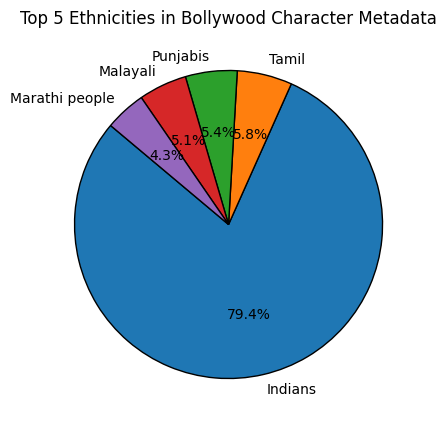

In [27]:
# Get the top 5 ethnicities by count
top_ethnicities = bollywood_characters['Actor_Ethnicity'].value_counts().nlargest(5)

# Plot a pie chart to show the distribution of the top 5 ethnicities
plt.figure(figsize=(5, 5))
plt.pie(top_ethnicities, labels=top_ethnicities.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Top 5 Ethnicities in Bollywood Character Metadata")
plt.show()

**Interactive pie chart**

In [28]:
pio.renderers.default = 'browser'

# Get the top 5 ethnicities by count
top_ethnicities = top_ethnicities.reset_index()
top_ethnicities.columns = ['Ethnicity', 'Count']
print(top_ethnicities)
# Create an interactive pie chart
fig = px.pie(top_ethnicities, values='Count', names='Ethnicity', title="Top 5 Ethnicities in Bollywood Character Metadata",
             hover_data=['Count'], labels={'Count':'Number of Characters'})
fig.update_traces(textinfo='percent+label')  # Add percentage display to the chart

        Ethnicity  Count
0         Indians  14685
1           Tamil   1068
2        Punjabis   1003
3        Malayali    937
4  Marathi people    795


In [29]:
# Show the interactive pie-chart
fig.show()

## 2. Gender Representation Analysis

**Non-interactive pie chart**

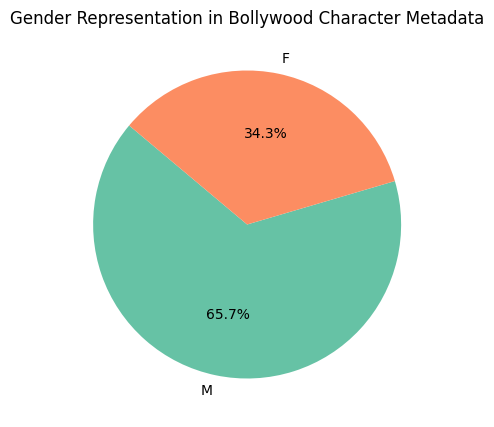

In [30]:
# Step 1: Calculate the counts of each gender in the Bollywood character data
gender_counts = bollywood_characters['Actor_Gender'].value_counts()

# Step 2: Create a non-interactive pie chart using Matplotlib
plt.figure(figsize=(5, 5))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title("Gender Representation in Bollywood Character Metadata")
plt.show()

**Non-interactive pie chart**

In [31]:
# Convert to DataFrame for easier plotting with Plotly
gender_counts_df = gender_counts.reset_index()
gender_counts_df.columns = ['Gender', 'Count']

# Step 2: Create a pie chart for gender distribution
fig = px.pie(gender_counts_df, values='Count', names='Gender', 
             title="Gender Representation in Bollywood Character Metadata",
             hover_data=['Count'], labels={'Count':'Number of Characters'})
fig.update_traces(textinfo='percent+label')

In [32]:
# Show the chart
fig.show()

## 3. Age Representation Analysis

### Overall Age Distribution
Display a histogram or box plot for the age distribution of all characters.

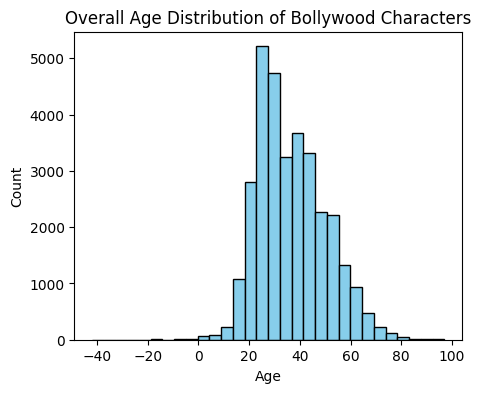

In [33]:
# Step 1: Overall Age Distribution (Non-Interactive)
plt.figure(figsize=(5, 4))
plt.hist(bollywood_characters['Actor_Age'].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Overall Age Distribution of Bollywood Characters")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [34]:
# Print overall average age
print(f"Overall average actor age in Bollywood movies is: {bollywood_characters['Actor_Age'].mean():.2f} years old.")

Overall average actor age in Bollywood movies is: 36.63 years old.


In [35]:
# Step 2: Overall Age Distribution (Interactive)
fig = px.histogram(bollywood_characters, x='Actor_Age', nbins=30, title="Overall Age Distribution of Bollywood Characters")
fig.update_layout(xaxis_title="Age", yaxis_title="Count")
fig.show()

### Gender-Based Comparison
 Display separate age distributions for male and female characters to compare differences.

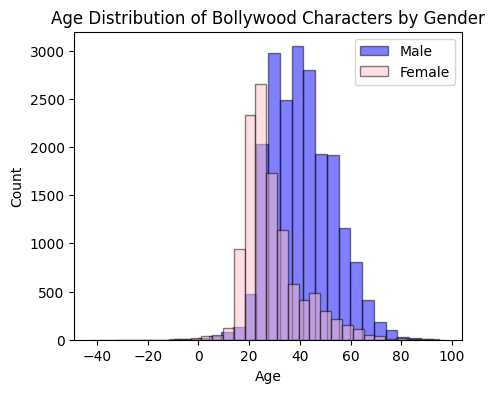

In [36]:
# Step 3: Age Distribution by Gender (Non-Interactive)
plt.figure(figsize=(5, 4))
male_ages = bollywood_characters[bollywood_characters['Actor_Gender'] == 'M']['Actor_Age'].dropna()
female_ages = bollywood_characters[bollywood_characters['Actor_Gender'] == 'F']['Actor_Age'].dropna()
plt.hist(male_ages, bins=30, color='blue', alpha=0.5, label='Male', edgecolor='black')
plt.hist(female_ages, bins=30, color='pink', alpha=0.5, label='Female', edgecolor='black')
plt.title("Age Distribution of Bollywood Characters by Gender")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend()
plt.show()

In [37]:
# Step 4: Age Distribution by Gender (Interactive)
fig_gender = px.histogram(bollywood_characters, x='Actor_Age', color='Actor_Gender', nbins=30,
                          title="Age Distribution of Bollywood Characters by Gender", barmode='overlay')
fig_gender.update_layout(xaxis_title="Age", yaxis_title="Count")
fig_gender.show()

In [38]:
# Calculate the average age for male and female characters separately
average_age_male = bollywood_characters[bollywood_characters['Actor_Gender'] == 'M']['Actor_Age'].mean()
average_age_female = bollywood_characters[bollywood_characters['Actor_Gender'] == 'F']['Actor_Age'].mean()
print(f"Overall average actor age for Males in Bollywood movies is: {average_age_male:.2f} years old.")
print(f"Overall average actor age for Females in Bollywood movies is: {average_age_female:.2f} years old.")

Overall average actor age for Males in Bollywood movies is: 40.92 years old.
Overall average actor age for Females in Bollywood movies is: 28.89 years old.


**=>This suggests that Bollywood movies tend to cast younger female characters on average compared to male characters. The question is, do these numbers represent real-world numbers and therefore reflect reality or do they represent an industry bias toward casting younger female roles relative to male roles? This is what we aim to find out with our compartive analysis!**